# LPC (Linear Predictive Coding) Comparison from Scrath and using Librosa
----

La codificación predictiva lineal (LPC), es un método de análisis de una señal digital el cual ha sido adoptado para el procesamiento de la señal vocal, dado que se adapta al modelamiento matemático del tracto vocal, que tiene como uno de sus aspectos más importantes el hecho de que la alta correlación existente entre muestras de la señal, permite calcular un valor particular como una combinación lineal de los valores anteriores de la misma, este aspecto es la base principal del estudio del modelamiento predictivo lineal.


La entrada consiste en una serie temporal que representa las amplitudes del habla recolectadas a intervalos fijos durante un período de tiempo.

La salida es una matriz de coeficientes que corresponden al modelo de fuente y filtro, y es mucho más compacta, por lo que este método puede usarse para comprimir audio.

## Implementacion propia

In [1]:
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from scipy.signal.windows import hann
from math import floor
from scipy.signal import lfilter
from numpy.random import randn 


In [2]:
# Reading file data
[sample_rate, pcm_data] = scipy.io.wavfile.read('curita.wav')
sample_rate

48000

pcm_data es un arreglo con las amplitudes de cada muestra; sample_rate es la cantidad de muestras de audio que se toman por segundo para representar una señal continua (como el sonido) en forma digital.

In [3]:
amplitudes = np.array(pcm_data)
amplitudes.shape

(670720,)

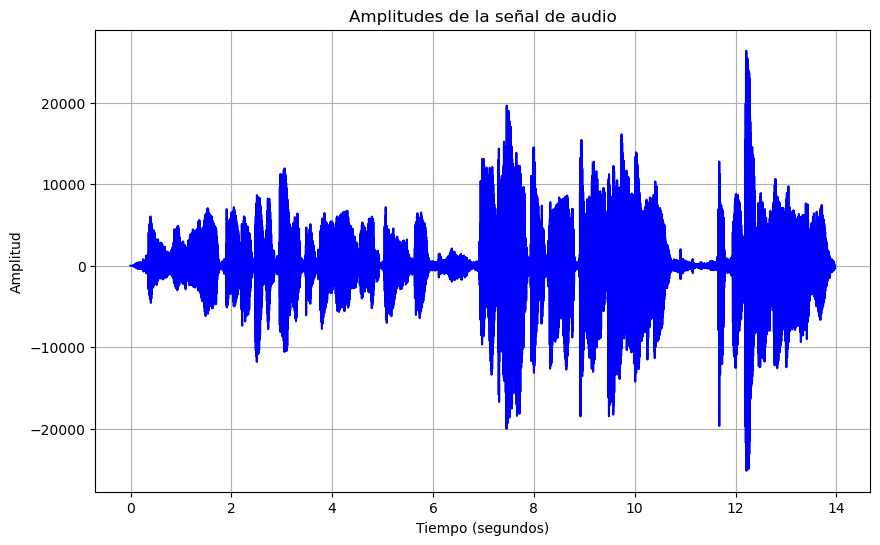

In [4]:
# Visualizacion de amplitudes en el tiempo (audio)
# El número total de muestras es len(pcm_data)
# El tiempo total es len(pcm_data) / sample_rate (en segundos)
time = np.linspace(0, len(pcm_data) / sample_rate, num=len(pcm_data))

# 3. Grafica las amplitudes de pcm_data en función del tiempo
plt.figure(figsize=(10, 6))
plt.plot(time, pcm_data, color='b')
plt.title("Amplitudes de la señal de audio")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

Con una senal de audio grande trataremos de normalizarla en escalas de  [-1.0] <= a <= [1.0], al igual que la taza de muestreo a una taza menor para un modelo mas pequeno

In [5]:
amplitudes = 0.9*amplitudes/max(abs(amplitudes))

In [6]:
target_sample_rate = 8000
target_size = int(len(amplitudes)*target_sample_rate/sample_rate)

amplitudes = resample(amplitudes, target_size)
sample_rate = target_sample_rate

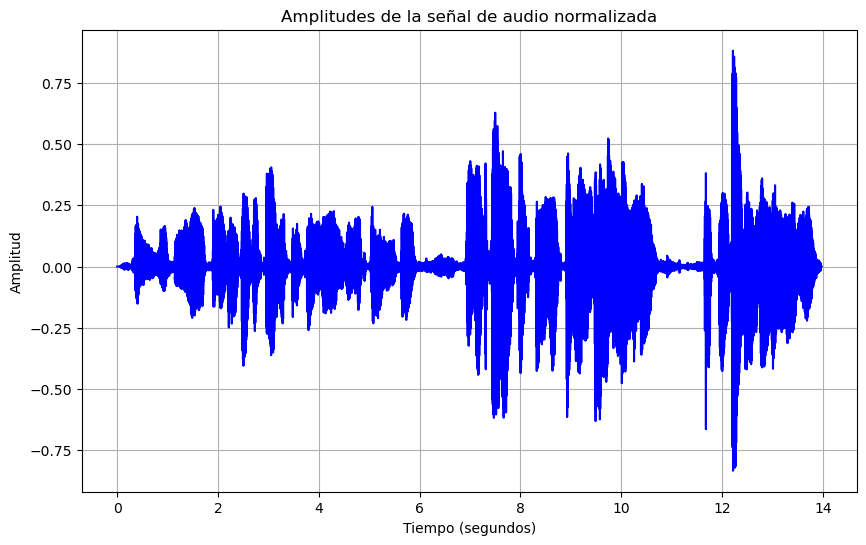

In [7]:
# Nueva senal normalizada:
time = np.linspace(0, len(amplitudes) / sample_rate, num=len(amplitudes))

# 3. Grafica las amplitudes de pcm_data en función del tiempo
plt.figure(figsize=(10, 6))
plt.plot(time, amplitudes, color='b')
plt.title("Amplitudes de la señal de audio normalizada")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

### Modelo LPC

Sea \( x_t \) la amplitud de nuestra señal en un instante \( t \). De acuerdo con el modelo fuente-filtro, esta es generada por una señal fuente \( e \) que pasa por un filtro resonante \( h \).

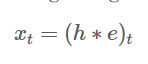

El \( * \) denota el operador de convolución. El modelo también asume que la señal actual depende de las \( p \) muestras anteriores, es decir, \( x_t-1, ..., x_t-p \), y que la fuente es constante, por lo que efectivamente:

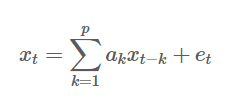

### Resolviendo el modelo
Tenemos entonces \( n-1 \) ecuaciones (una para cada muestra, excepto la primera), y debemos determinar los \( p \) coeficientes a = [a_1, ..., a_p]^T ) y e = [e_2, ..., e_n] ):

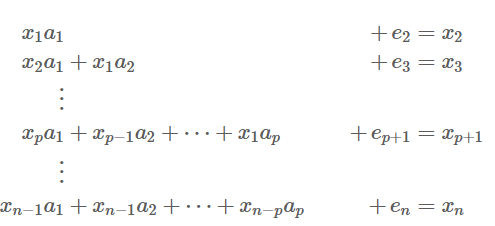

El enfoque adoptado en [1] es ignorar los errores y resolver para \( a \), pero intentando minimizar el error. El error es entonces \( e \).

### Definiendo la matriz

Más precisamente, definimos la matriz \( X \), donde la fila \( i \)-ésima es:

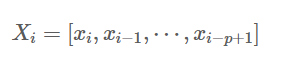

Asumimos que x_i = 0 si i <= 0 . Definimos \( b \) como el vector columna: [x_1, ..., x_n]^T
Luego, resolvemos el sistema lineal Xa = b para a, minimizando el cuadrado del error.



In [8]:
def create_overlapping_blocks(x, w, R = 0.5):
    n = len(x)
    nw = len(w)
    step = floor(nw * (1 - R))
    nb = floor((n - nw) / step) + 1

    B = np.zeros((nb, nw))

    for i in range(nb):
        offset = i * step
        B[i, :] = w * x[offset : nw + offset]

    return B

def add_overlapping_blocks(B, w, R = 0.5):
    [count, nw] = B.shape
    step = floor(nw * R)

    n = (count-1) * step + nw

    x = np.zeros((n, ))

    for i in range(count):
        offset = i * step
        x[offset : nw + offset] += B[i, :]

    return x

#Encoding LPC
def make_matrix_X(x, p):
    n = len(x)
    # [x_n, ..., x_1, 0, ..., 0]
    xz = np.concatenate([x[::-1], np.zeros(p)])

    X = np.zeros((n - 1, p))
    for i in range(n - 1):
        offset = n - 1 - i
        X[i, :] = xz[offset : offset + p]
    return X

def solve_lpc(x, p, ii):
    b = x[1:]

    X = make_matrix_X(x, p)

    a = np.linalg.lstsq(X, b.T)[0]

    e = b - np.dot(X, a)
    g = np.var(e)

    return [a, g]

def lpc_encode(x, p, w):
    B = create_overlapping_blocks(x, w)
    [nb, nw] = B.shape

    A = np.zeros((p, nb))
    G = np.zeros((1, nb))

    for i in range(nb):
        [a, g] = solve_lpc(B[i, :], p, i)

        A[:, i] = a
        G[:, i] = g

    return [A, G]

def run_source_filter(a, g, block_size):
    src = np.sqrt(g)*randn(block_size, 1) # noise

    b = np.concatenate([np.array([-1]), a])

    x_hat = lfilter([1], b.T, src.T).T

    # convert Nx1 matrix into a N vector
    return np.squeeze(x_hat)

def lpc_decode(A, G, w, lowcut = 0):

    [ne, n] = G.shape
    nw = len(w)
    [p, _] = A.shape

    B_hat = np.zeros((n, nw))

    for i in range(n):
        B_hat[i,:] = run_source_filter(A[:, i], G[:, i], nw)

    # recover signal from blocks
    x_hat = add_overlapping_blocks(B_hat, w);

    return x_hat



In [9]:
# Encode
# 30ms Hann window
sym = False # periodic
w = hann(floor(0.03*sample_rate), sym)

# Encode
p = 6 # number of poles
[A, G] = lpc_encode(amplitudes, p, w)

# Print stats
original_size = len(amplitudes)
model_size = A.size + G.size
print('Original signal size:', original_size)
print('Encoded signal size:', model_size)
print('Data reduction:', original_size/model_size)

xhat = lpc_decode(A, G, w)

scipy.io.wavfile.write("decoded.wav", sample_rate, xhat)

C:\Users\MrJel\AppData\Local\Temp\ipykernel_27976\1679443698.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = np.linalg.lstsq(X, b.T)[0]


Original signal size: 111786
Encoded signal size: 6510
Data reduction: 17.17142857142857


Text(0.5, 1.0, 'LP Model Forward Prediction')

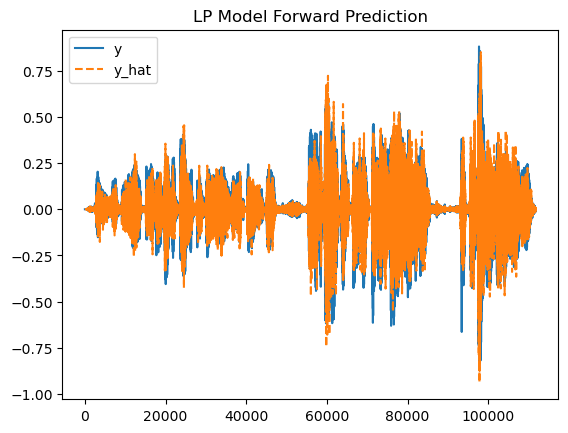

In [19]:
fig, ax = plt.subplots()
ax.plot(amplitudes)
ax.plot(xhat, linestyle='--')
ax.legend(['y', 'y_hat'])
ax.set_title('LP Model Forward Prediction')

## Usando Librosa


In [20]:
import librosa

Text(0.5, 1.0, 'LP Model Forward Prediction')

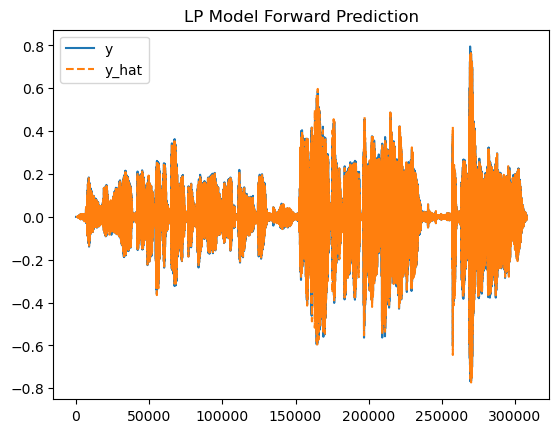

In [27]:
y, sr = librosa.load('curita.wav')
a = librosa.lpc(y, order=6)
b = np.hstack([[0], -1 * a[1:]])
y_hat = scipy.signal.lfilter(b, [1], y)
fig, ax = plt.subplots()
ax.plot(y)
ax.plot(y_hat, linestyle='--')
ax.legend(['y', 'y_hat'])
ax.set_title('LP Model Forward Prediction')

In [39]:
xhat

array([-3.01726591e-10,  1.21213550e-09, -2.55205524e-09, ...,
        6.14650090e-03,  2.53399512e-03, -2.34555376e-03])

In [40]:
y_hat

array([0., 0., 0., ..., 0., 0., 0.])

Hay una diferencia en como la señal es leida inicialmente y como es normalizada